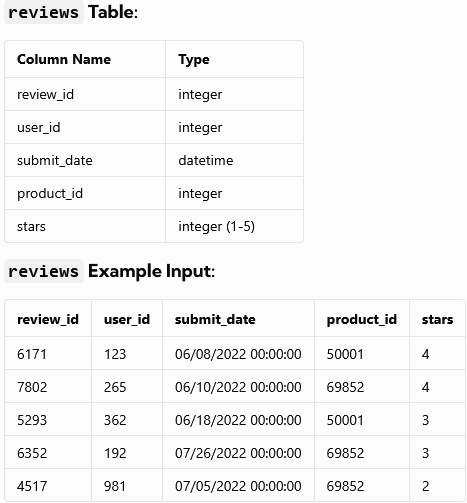

In [ ]:
SELECT user_id, stars 
FROM reviews 
WHERE stars = 3;

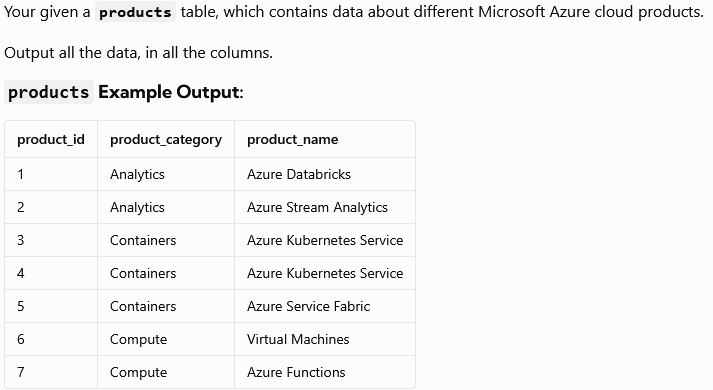

In [ ]:
SELECT * FROM products;

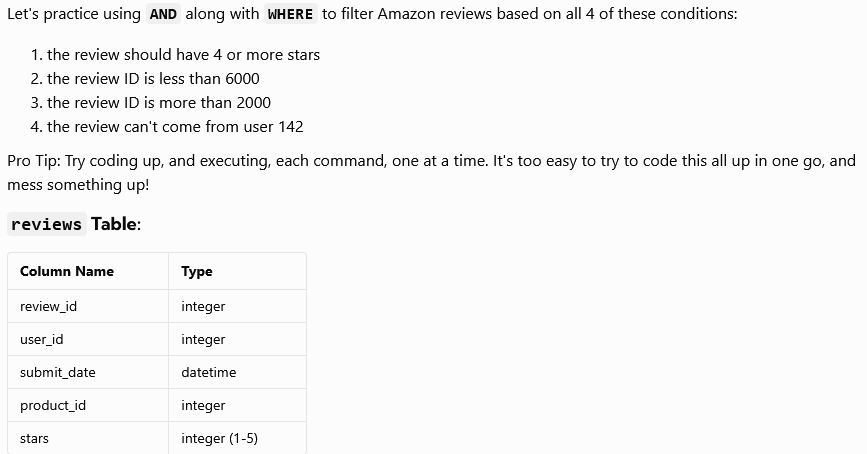

In [ ]:
SELECT *
FROM reviews
WHERE stars >= 4
  AND review_id < 6000
  AND review_id > 2000
  AND user_id != 142;

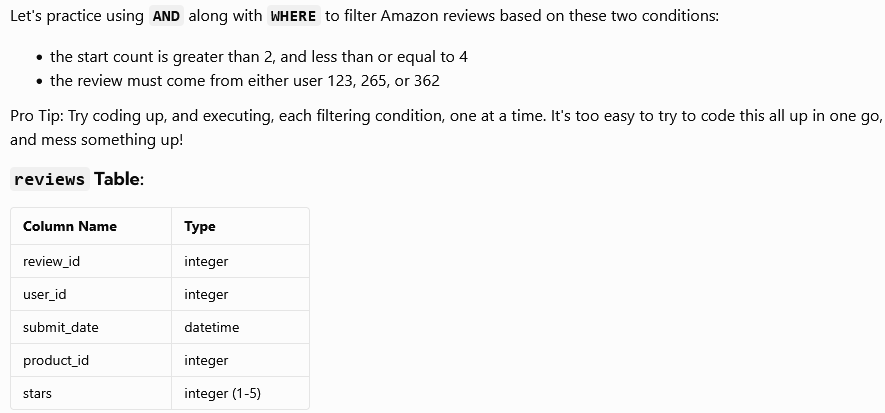

In [ ]:
SELECT *
FROM reviews
WHERE (stars > 2 AND stars <= 4)
  AND (user_id = 123 OR user_id = 265 OR user_id = 362);

# It can be done using IN statement:

SELECT *
FROM reviews
WHERE (stars IN (3, 4))
  AND (user_id IN (123, 265, 362))